In [3]:
from PIL import Image
import base64
from io import BytesIO
import os
import gradio as gr
from openai import OpenAI
from dotenv import load_dotenv
from pydub import AudioSegment
from pydub.playback import play
from IPython.display import Audio, display
import json
import uuid
import random
import datetime

In [3]:
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')

if openai_api_key and openai_api_key.startswith('sk-proj-'):
    print('API Key exists, good to go')
else:
    print('API Key doesnt exist, troubleshoot the problem!')

API Key exists, good to go


In [ ]:
openai = OpenAI()
MODEL = 'gpt-4o-mini'

system_prompt =  "You are a helpful assistant for an Airline called FlighAI. "
system_prompt += "Give short, courteous answers, not more than 1 sentence. "
system_prompt += "Always be accurate. If you don't know the answer, say so."


In [17]:
def get_ticket_price(destination_city):
    ticekt_prices = {'london': '$699', 'berlin': '$599', 'sydney': '$899', 'paris': '$1000', 'dubai': '$399'}
    city = destination_city.lower()
    return ticekt_prices.get(city, 'Unkown')



import uuid
from datetime import datetime

def make_flight_booking(passenger_name, departure_date, return_date, destination_city, flight_class, airways):
    booking_reference = str(uuid.uuid4())[:6].upper()
    
    available_airways = ['flightai', 'jetsky', 'gofly']
    available_flight_class = ['first', 'business', 'economy']
    
    airways_lower = airways.lower()
    flight_class_lower = flight_class.lower()

    # Validate airways (case-insensitive)
    if airways_lower not in available_airways:
        return f'{airways} is not available. Select from: ["FlightAI", "JetSky", "GoFLY"].'

    # Validate dates
    try:
        dep_date = datetime.strptime(departure_date, "%Y-%m-%d")
        ret_date = datetime.strptime(return_date, "%Y-%m-%d")

        if ret_date <= dep_date:
            return {"error": "Return date must be after the departure date."}
    except ValueError:
        return {"error": "Dates must be in YYYY-MM-DD format."}

    # Validate flight class (case-insensitive)
    if flight_class_lower not in available_flight_class:
        return f'{flight_class} is not available. Select from: ["First", "Business", "Economy"].'

    # Create a booking response
    booking_response = {
        "passenger_name": passenger_name,
        "booking_reference": booking_reference,
        "departure_date": departure_date,
        "return_date": return_date,
        "destination_city": destination_city,
        "flight_class": flight_class.capitalize(),
        "airways": airways.capitalize()        
    }

    return booking_response


In [18]:
price_tool_response_structure = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, "
    "for example, when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to.",
            },
        },
        "required": ["destination_city"],
        "additionalProperites": False
    }
}

booking_tool_response_structure = {
    "name": "make_flight_booking",
    "description": "Get the relevant details from the user ony-by-one for making a flight booking to a destination city. Call this whenever you need to make a flight booking. "
    "for example, when a customer says 'I want to book a flight.'",
    "parameters": {
        "type": "object",
        "properties": {
            "passenger_name": {
                "type": "string",
                "description": "The name of the customer."
            },
             "departure_date": {
                "type": "string",
                "description": "Date of departure in YYYY-MM-DD format."
            },
             "return_date": {
                "type": "string",
                "description": "Date of return in YYYY-MM-DD format."
            },
             "destination_city": {
                "type": "string",
                "description": "The city that the customer wansts to travel to."
            },
             "flight_class": {
                "type": "string",
                "description": "The class that the customer wants to select for a flight."
            },
             "airways": {
                "type": "string",
                "description": "The name of the airways that the customers wants to travel in."
            },

        },
        "required": ["passenger_name", "departure_date", "return_date", "destination_city", "flight_class", "airways"],
        "additionalProperties": False
    }
}

In [ ]:
tools_list = [
    {'type': 'function', 'function': price_tool_response_structure},
    {'type': 'function', 'function': booking_tool_response_structure}
]

In [ ]:
def handle_price_tool(assistant_message):
    tool_call = assistant_message.tool_calls[0]
    arguments = json.loads(assistant_message.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price.get(city)
    tool_response = {
        'role': 'tool',
        'content': json.dumps({'destination_city': city, 'price': price}),
        'tool_call_id': tool_call.id
    }

    return tool_response, city


def handle_booking_tool(assistant_message):
    tool_call = assistant_message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)

    name = arguments.get('passenger_name')
    dep_date = arguments.get('departure_date')
    ret_date = arguments.get('return_date')
    dest_city = arguments.get('destination_city')
    flight_class = arguments.get('flight_class')
    airways = arguments.get('airways')

    booking_arguments = make_flight_booking(name, dep_date, ret_date, dest_city, flight_class, airways)

    booking_response = {
        'role': 'tool',
        'content': json.dumps(booking_arguments),
        'tool_call_id': tool_call.id
    }

    return booking_response


In [ ]:
def airline_customer_support_chatbot(user_prompt, history):
    conversation = [{'role': 'system', 'content': system_prompt}] + history + [{'role': 'system', 'content': user_prompt}]

    response = openai.chat.completions.create(
        model= MODEL,
        messages= conversation, 
        tools= tools_list,
        tool_choice= 'auto',
        temperature= 0.5
    )

    if response.choices[0].finish_reason == 'tool_calls':
        assistant_response = response.choices[0].message
        tool_call_name = assistant_response.tool_calls[0].function.name

        if tool_call_name == 'handle_price_tool':
            tool_response, city = handle_price_tool(assistant_response)
        elif tool_call_name == 'handle_booking_tool':
            tool_response = handle_booking_tool(assistant_response)
            

        conversation.append(assistant_response)
        conversation.append(tool_response)

        response = openai.chat.completions.create(
            model= MODEL,
            messages= conversation
        )
    
    return response.choices[0].message.content


In [8]:
def artist(user_prompt):
    image = openai.images.generate(
        model= 'dall-e-3',
        prompt= user_prompt,
        size= '1024x1024',
        n= 1,
        response_format= 'b64_json'
    )
    image_base64 = image.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

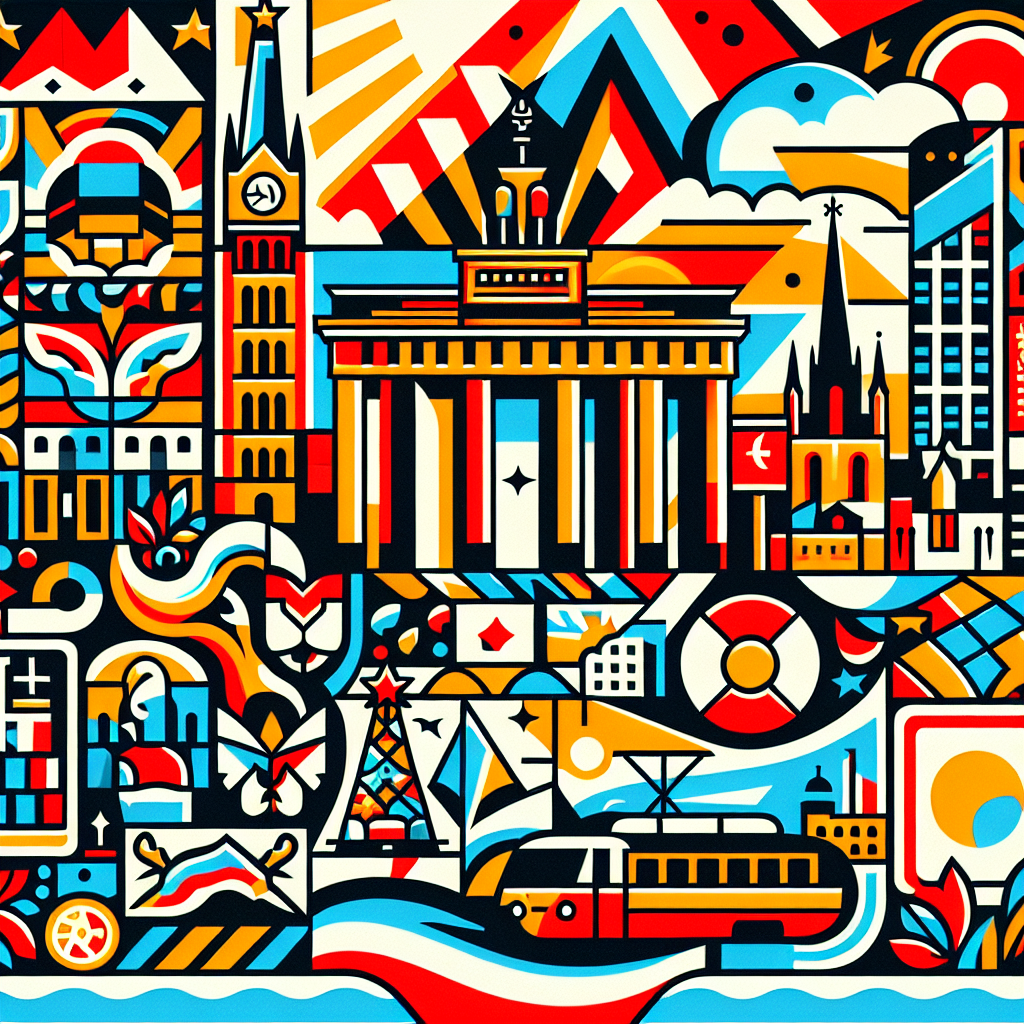

In [10]:
prompt = "An image representing a vacation in Berlin, showing tourist spots and everything unique about Berlin, in a vibrant pop-art style"
image = artist(prompt)
display(image)

In [ ]:
def talker(user_prompt):
    speech = openai.audio.speech.create(
        model= 'tts-1',
        voice= 'nova',
        input= user_prompt
    )
    audio_stream = BytesIO(speech.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())
        
    display(Audio(output_filename, autoplay=True))
    

In [18]:
talker('Hello! How are you?')